<a href="https://colab.research.google.com/github/j-physics/Mech_Interp_Exploratory/blob/main/singlelayer_FAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformer-lens

In [ ]:
#import necessary libraries or packages
import torch
import transformer_lens
from transformer_lens import HookedTransformer

#check GPU is working right
print(f"GPU available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

GPU available: True
Device: NVIDIA A100-SXM4-40GB


In [ ]:
#load a small model (e.g., gpt2-small, pythia-70m)
model = HookedTransformer.from_pretrained("pythia-70m", device="cuda")

#check to see model is loading
text = "Hi, my name is Jessica."
tokens = model.to_tokens(text)
logits = model(tokens)
print(f"Tokens shape: {tokens.shape}")
print(f"Logits shape: {logits.shape}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Loaded pretrained model pythia-70m into HookedTransformer
Tokens shape: torch.Size([1, 8])
Logits shape: torch.Size([1, 8, 50304])


In [ ]:
!pip install sae_lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.0/161.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.2/267.2 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.3/216.3 kB 20.1 MB/s eta 0:00:00
  Created wheel for py2store: filename=py2store-0.1.22-py3-none-any.whl size=118389 sha256=dfa3273c26301bd3a97ae90a795beeee229c44c83fb56f68782b211972b0aabd
  Stored in directory: /root/.cache/pip/wheels/59/49/01/72e7719a1a5d8d2ed6d557a6b39adc7204094219454c1a15a7
Successfully built py2store
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.5.0
    Uninstalling tenacity-8.5.0:
      Successfully uninstalled tenacity-8.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [ ]:
#integrate SAEs from TransformerLens
from transformer_lens import HookedTransformer
from sae_lens import SAE

#Load SAE for a specific layer(s)
sae, cfg_dict, sparsity = SAE.from_pretrained_with_cfg_and_sparsity(
    release="ctigges/pythia-70m-deduped__res-sm_processed",
    sae_id="2-res-sm",
    device="cuda"
)

cfg.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

2-res-sm/sae_weights.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

2-res-sm/sparsity.safetensors:   0%|          | 0.00/131k [00:00<?, ?B/s]

In [ ]:
#feature activation analysis (FAA)

#Testing some text out
text = "There is a tiger in the room"
tokens = model.to_tokens(text)

#Getting the activations at a single layer
_, cache = model.run_with_cache(tokens)
layer_acts = cache["blocks.2.hook_resid_post"]

#Run through SAE to get feature activations of singlelayer
feature_acts = sae.encode(layer_acts)

#Seeing which features fired
print(f"Shape: {feature_acts.shape}") #should be in the format [batch, seq_len, num_feat]
print(f"Non-zero features: {(feature_acts > 0).sum()}")

#Find the top activating features
top_features = feature_acts[0, -1].topk(10) #top 10 at the last token
print(f"Top features: {top_features.indices}")
print(f"Activations: {top_features.values}")

Shape: torch.Size([1, 8, 32768])
Non-zero features: 8739
Top features: tensor([27045, 32604, 16978, 17575, 23734, 19777, 14190,  6079,  7552, 20236],
       device='cuda:0')
Activations: tensor([1.5125, 1.2771, 1.2396, 1.2269, 0.8035, 0.7915, 0.7530, 0.7471, 0.7292,
        0.6755], device='cuda:0', grad_fn=<TopkBackward0>)


In [ ]:
#Looking at each token position now
tokens_str = model.to_str_tokens(text)
print("Tokens:", tokens_str)

# for pos in range(len(tokens_str)):
#   top_at_pos = feature_acts[0, pos].topk(5)
#   print(f"\nToken {pos} ('{tokens_str[pos]}'):")
#   print(f" Top features: {top_at_pos.indices.tolist()}")
#   #print(f" Activations: {top_at_pos.values.tolist()}")

#nice format to show what sentence I am analyzing
print("=" * 60)
print(f"Analyzing: '{text}'")
print("=" * 60)

#What top features activate for each token
for pos, token in enumerate(tokens_str):
  top_features = feature_acts[0, pos].topk(3) #top three features
  print(f"\nPosition {pos}: '{token}'")
  print(f" Top 3 features: {top_features.indices.tolist()}")
  print(f" Activations: {[f'{x: .3f}' for x in top_features.values.tolist()]}")


Tokens: ['<|endoftext|>', 'There', ' is', ' a', ' tiger', ' in', ' the', ' room']
Analyzing: 'There is a tiger in the room'

Position 0: '<|endoftext|>'
 Top 3 features: [11698, 3599, 25082]
 Activations: [' 31.524', ' 13.575', ' 12.890']

Position 1: 'There'
 Top 3 features: [26906, 779, 21516]
 Activations: [' 0.734', ' 0.621', ' 0.538']

Position 2: ' is'
 Top 3 features: [14190, 21516, 5920]
 Activations: [' 0.982', ' 0.948', ' 0.822']

Position 3: ' a'
 Top 3 features: [15823, 12085, 24046]
 Activations: [' 1.723', ' 1.227', ' 1.135']

Position 4: ' tiger'
 Top 3 features: [12132, 18562, 7322]
 Activations: [' 1.686', ' 1.563', ' 1.490']

Position 5: ' in'
 Top 3 features: [14190, 14093, 6034]
 Activations: [' 1.931', ' 1.216', ' 0.935']

Position 6: ' the'
 Top 3 features: [8127, 3345, 26842]
 Activations: [' 1.754', ' 1.454', ' 1.452']

Position 7: ' room'
 Top 3 features: [1770, 27045, 19836]
 Activations: [' 1.546', ' 1.123', ' 0.954']


In [ ]:
#What about for some other sentences? (including the previous test text)
test_sentences = {
    "original": "The tiger is in the room",
    "changed_subject": "The wolf is in the room", #changing the subject
    "changed_verb": "The tiger jumped in the room", #change of verb
    "multiple_subjects": "The tiger and the wolf are in the room", #multiple subjects
}

#collect the activations for each sentence
results = {}

for name, sentence in test_sentences.items():
  tokens = model.to_tokens(sentence)
  tokens_str = model.to_str_tokens(sentence)

  _, cache = model.run_with_cache(tokens)
  layer_activate = cache["blocks.2.hook_resid_post"]
  feature_activate = sae.encode(layer_activate)

  results[name] = {
        'tokens': tokens_str,
        'activations': feature_activate[0] #[seq_len, num_features]
  }

  #Comparing which features appear in ALL variations
  #Getting the top features from each
  all_top_features = []
  for name, data in results.items():
    top = data['activations'][-1].topk(10).indices.tolist() #last token
    all_top_features.extend(top)

  #Find common features
  from collections import Counter
  feature_counts = Counter(all_top_features)

  print("=" * 60)
  print("Feature Consistency Analysis")

  print("Features that consistently activate across variations:")
  print(common_features)


Features that consistently activate across variations:
[27045, 32604, 11175, 24101, 3939, 16978, 23288, 17575, 1770, 19777]
Features that consistently activate across variations:
[27045, 32604, 11175, 24101, 3939, 23288, 17575, 1770, 16978, 19777]
Features that consistently activate across variations:
[32604, 17575, 27045, 11175, 24101, 3939, 16978, 23288, 1770, 19777]
Features that consistently activate across variations:
[32604, 27045, 11175, 24101, 3939, 16978, 23288, 17575, 1770, 1437]


In [ ]:
#What about for some other sentences? (including the previous test text)
test_sentences = {
    "original": "The tiger is in the room",
    "changed_subject": "The wolf is in the room", #changing the subject
    "changed_verb": "The tiger jumped in the room", #change of verb
    "multiple_subjects": "The tiger and the wolf are in the room", #multiple subjects
}

#collect the activations for each sentence
results = {}

for name, sentence in test_sentences.items():
  tokens = model.to_tokens(sentence)
  tokens_str = model.to_str_tokens(sentence)

  _, cache = model.run_with_cache(tokens)
  layer_activate = cache["blocks.2.hook_resid_post"]
  feature_activate = sae.encode(layer_activate)

  results[name] = {
        'tokens': tokens_str,
        'activations': feature_activate[0] #[seq_len, num_features]
  }

#Comparing which features appear in ALL variations
#Getting the top features from each
all_top_features = []
for name, data in results.items():
    top = data['activations'][-1].topk(10).indices.tolist() #last token
    all_top_features.extend(top)

#Find common features
from collections import Counter
feature_counts = Counter(all_top_features)

print("=" * 60)
print("Feature Consistency Analysis")
print("=" * 60)
print("\nFeatures that appear most frequently across variations:")
for feat, count in feature_counts.most_common(10):
  print(f"   Feature {feat}: appears in {count}/{len(test_sentences)} variations")


Feature Consistency Analysis

Features that appear most frequently across variations:
   Feature 32604: appears in 4/4 variations
   Feature 27045: appears in 3/4 variations
   Feature 11175: appears in 3/4 variations
   Feature 24101: appears in 3/4 variations
   Feature 3939: appears in 3/4 variations
   Feature 16978: appears in 3/4 variations
   Feature 23288: appears in 3/4 variations
   Feature 17575: appears in 3/4 variations
   Feature 1770: appears in 3/4 variations
   Feature 1437: appears in 2/4 variations


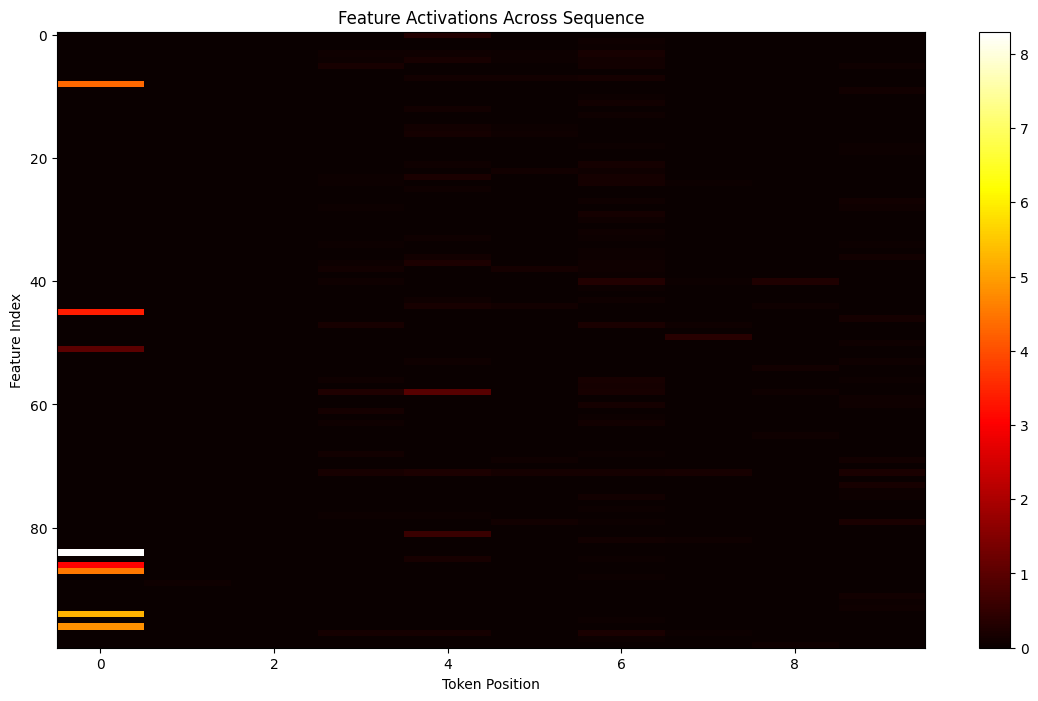

In [ ]:
#let's visualize what is happening
import matplotlib.pyplot as plt

#Generate a heatmap of feature activations across tokens
activations = feature_acts[0].cpu().detach() # [seq_len, num_featueres]

#Just plotting features that activated
active_mask = (activations > 0).any(dim=0)
active_features = activations[:, active_mask]

plt.figure(figsize=(14,8))
plt.imshow(active_features.T[:100], aspect='auto', cmap='hot')
plt.xlabel('Token Position')
plt.ylabel('Feature Index')
plt.title('Feature Activations Across Sequence')
plt.colorbar()
plt.show()